In [1]:
from pathlib import Path
import numpy as np
import pprint

from myTools.read_spikeglx import get_exp_dir, get_geometry, read_spikeglx_meta

from probeinterface import Probe
from probeinterface.plotting import plot_probe

import spikeinterface as si
# import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
# import spikeinterface.postprocessing as spost
# import spikeinterface.qualitymetrics as sqm
# import spikeinterface.comparison as sc
import spikeinterface.exporters as sexp
# import spikeinterface.curation as scur
# import spikeinterface.widgets as sw


In [6]:
### Select experiment ###

from pathlib import Path
from myTools.read_spikeglx import get_exp_dir, get_geometry, read_spikeglx_meta
root_dir = Path(r"C:\Users\tanaka-users\NeuData")
exp_name = "pe7w1_ep001_001"
g_name = "_g0"
t_name = "_t0"

exp_dir = get_exp_dir(root_dir, exp_name)
exp_dir

WindowsPath('C:/Users/tanaka-users/NeuData/pe7w1_ep001_001')

In [7]:
### Fetch meta and bin files ###

meta_name_ap = exp_dir.name + g_name + t_name + ".imec0.ap.meta"
bin_name_ap = exp_dir.name + g_name + t_name + ".imec0.ap.bin"
meta_name_lf = exp_dir.name + g_name + t_name + ".imec0.lf.meta"
bin_name_lf = exp_dir.name + g_name + t_name + ".imec0.lf.bin"
meta_name_obx = exp_dir.name + g_name + t_name + ".obx0.obx.meta"
bin_name_obx = exp_dir.name + g_name + t_name + ".obx0.obx.bin"

sub_dir_name = exp_dir.name + g_name
subsub_dir_name = exp_dir.name + g_name + "_imec0"

bin_fpath_ap = exp_dir / sub_dir_name / subsub_dir_name / bin_name_ap
meta_fpath_ap = exp_dir / sub_dir_name / subsub_dir_name / meta_name_ap
bin_fpath_lf = exp_dir / sub_dir_name / subsub_dir_name / bin_name_lf
meta_fpath_lf = exp_dir / sub_dir_name / subsub_dir_name / meta_name_lf
bin_fpath_obx = exp_dir / sub_dir_name / bin_name_obx
meta_fpath_obx = exp_dir / sub_dir_name / meta_name_obx

meta_ap = read_spikeglx_meta(meta_fpath_ap)
meta_lf = read_spikeglx_meta(meta_fpath_lf)
meta_obx = read_spikeglx_meta(meta_fpath_obx)


In [8]:
### Get recording info ###

sampling_frequency = float(meta_ap['imSampRate'])
num_channels = int(meta_ap['nSavedChans'])
num_frames = int(meta_ap.get('fileSizeBytes', 0)) // (num_channels * 2)  # 2 bytes per sample (int16)
print(f"{sampling_frequency}Hz - {num_channels}chan - {num_frames / sampling_frequency:.2f} sec")

30000.0Hz - 385chan - 319.70 sec


In [9]:
### Get AP recording ###

import spikeinterface as si  # import core only
ap_rec = si.read_binary(
    file_paths=bin_fpath_ap,
    sampling_frequency=sampling_frequency,
    num_channels=num_channels,
    dtype='int16',
    time_axis=0,  # time x channels
    is_filtered=False,
)
ap_channel_ids = ap_rec.get_channel_ids()[:num_channels-1]
recording = ap_rec.select_channels(ap_channel_ids)
recording

ChannelSliceRecording: 384 channels - 30.0kHz - 1 segments - 9,591,045 samples 
                       319.70s (5.33 minutes) - int16 dtype - 6.86 GiB

In [10]:
### Get probe geometry ###

import numpy as np
geometry = get_geometry(meta_ap)
unique_x = np.sort(np.unique(geometry[:,0]))
print(f"Unique x positions: {unique_x}")
unique_y = np.sort(np.unique(geometry[:,1]))
print(f"Unique y positions: {unique_y}")

Unique x positions: [15.5 21.5 27.5 33.5 39.5 45.5 51.5 57.5]
Unique y positions: [  0.   6.  12.  18.  24.  30.  36.  42.  48.  54.  60.  66.  72.  78.
  84.  90.  96. 102. 108. 114. 120. 126. 132. 138. 144. 150. 156. 162.
 168. 174. 180. 186. 192. 198. 204. 210. 216. 222. 228. 234. 240. 246.
 252. 258. 264. 270. 276. 282.]


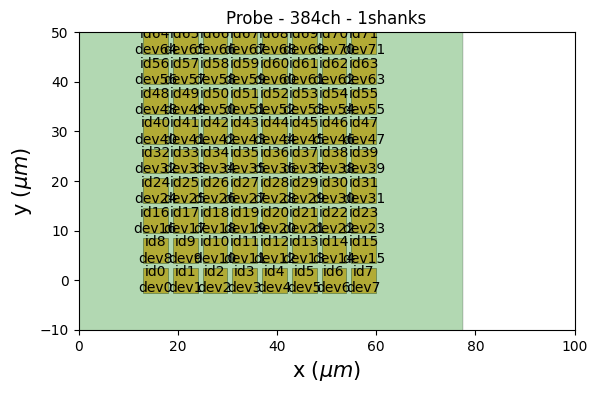

In [11]:
### Set probe to recording ###

from probeinterface import Probe
from probeinterface.plotting import plot_probe

# recordingが未定義の場合は読み込む
if 'recording' not in locals():
    recording = si.load(exp_dir / "kilosort4" / "pp_rec")

# geometryをy座標昇順、同yではx座標昇順でソート
# lexsortの引数は後ろから順にソートされるので、(x, y)の順で指定するとy優先、同yではxでソート
sorted_indices = np.lexsort((geometry[:, 0], geometry[:, 1]))  # y座標優先、同yではx座標でソート
sorted_geometry = geometry[sorted_indices]

# ソートされたgeometryでprobeを作成
probe = Probe(ndim=2, si_units='um')
probe.set_contacts(positions=sorted_geometry, shapes='square', shape_params={'width': 5})

# device_channel_indicesはソート後の順序に合わせて設定（0, 1, 2, ...）
probe.set_device_channel_indices(np.arange(probe.get_contact_count()))
probe.set_contact_ids(np.arange(probe.get_contact_count()))
probe.create_auto_shape()

plot_probe(probe, with_contact_id=True, with_device_index=True, xlims=(0, 100), ylims=(-10, 50))

# recordingのチャンネル順序をソートされた順序に合わせて並び替え
# 現在のrecordingのチャンネルIDを取得
current_channel_ids = recording.get_channel_ids()

# sorted_indicesを使ってチャンネルを再配置
# 注意: current_channel_idsの順序が元のgeometryの順序と一致していることを前提
sorted_channel_ids = [current_channel_ids[i] for i in sorted_indices]

# チャンネルをソートされた順序で選択
recording = recording.select_channels(channel_ids=sorted_channel_ids)

# recordingにプローブ情報を設定
recording = recording.set_probe(probe, in_place=False)

In [12]:
### Set gain and offset to recording ###

im_ai_range_max = float(meta_ap.get('imAiRangeMax', 0.6))
im_ai_range_min = float(meta_ap.get('imAiRangeMin', -0.6))
im_max_int = int(meta_ap.get('imMaxInt', 512))
ap_gain = float(meta_ap.get('imChan0apGain', 500))

# μVへの変換係数
gain_to_uv = (im_ai_range_max - im_ai_range_min) / (2 * im_max_int * ap_gain) * 1e6

# 現在のrecordingのチャンネル数を取得（SYNCチャンネルを除外した場合は384）
current_num_channels = recording.get_num_channels()

# すべてのチャンネルに同じゲインを設定
gains = np.full(current_num_channels, gain_to_uv, dtype='float32')
recording.set_channel_gains(gains)

# オフセットは0に設定
offsets = np.zeros(current_num_channels, dtype='float32')
recording.set_channel_offsets(offsets)
recording

ChannelSliceRecording: 384 channels - 30.0kHz - 1 segments - 9,591,045 samples 
                       319.70s (5.33 minutes) - int16 dtype - 6.86 GiB

In [13]:
### Check GPU memory ###

import torch
import gc

print("実行前のGPUメモリ状態:")
if torch.cuda.is_available():
    print(f"  割り当て済み: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
    print(f"  予約済み: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")
    
    # GPUキャッシュをクリア
    torch.cuda.empty_cache()
    gc.collect()
    
    print("\nクリア後のGPUメモリ状態:")
    print(f"  割り当て済み: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
    print(f"  予約済み: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")
else:
    print("  CUDAが利用できません")

実行前のGPUメモリ状態:
  割り当て済み: 0.00 GB
  予約済み: 0.00 GB

クリア後のGPUメモリ状態:
  割り当て済み: 0.00 GB
  予約済み: 0.00 GB


In [14]:
### Setting sorters ###

do_preprocess = True
do_runsort = True

# sorters = ["dartsort", "kilosort4", "spykingcircus2"]
sorters = ["kilosort4"]
# sorters = ["spykingcircus2"]
# sorters = ["dartsort"]

sort_params_ds = ss.DARTsortSorter.default_params()
sort_params_ks4 = ss.Kilosort4Sorter.default_params()
sort_params_sc2 = ss.Spykingcircus2Sorter.default_params()

# DARTsort用パラメータ（メモリ削減版）

# Kilosort4用パラメータ
sort_params_ks4["torch_device"] = "cuda"
sort_params_ks4["save_extra_vars"] = True
# Spykingcircus2用パラメータ（必要に応じて調整）

# パラメータ辞書を作成
sort_params_dict = {
    "dartsort": sort_params_ds,
    "kilosort4": sort_params_ks4,
    "spykingcircus2": sort_params_sc2
}

# 選択されたソーターのパラメータを表示
print("\n" + "="*20 + " parameter " + "="*20)
for sorter in sorters:
    print(f"\n{'='*5} {sorter} {'='*5}")
    pprint.pprint(sort_params_dict[sorter])


==================== parameter ====================

===== kilosort4 =====
{'Th_learned': 8,
 'Th_single_ch': 6,
 'Th_universal': 9,
 'acg_threshold': 0.2,
 'artifact_threshold': inf,
 'bad_channels': None,
 'batch_size': 60000,
 'binning_depth': 5,
 'ccg_threshold': 0.25,
 'chunk_duration': '1s',
 'clear_cache': False,
 'cluster_downsampling': 1,
 'cluster_neighbors': 10,
 'delete_recording_dat': True,
 'dmin': None,
 'dminx': 32,
 'do_CAR': True,
 'do_correction': True,
 'drift_smoothing': [0.5, 0.5, 0.5],
 'duplicate_spike_ms': 0.25,
 'fs': 30000,
 'highpass_cutoff': 300,
 'invert_sign': False,
 'keep_good_only': False,
 'max_channel_distance': 32,
 'max_cluster_subset': 25000,
 'max_peels': 100,
 'max_threads_per_worker': 1,
 'min_template_size': 10,
 'mp_context': None,
 'n_jobs': 1,
 'n_pcs': 6,
 'n_templates': 6,
 'nblocks': 1,
 'nearest_chans': 10,
 'nearest_templates': 100,
 'nskip': 25,
 'nt': 61,
 'nt0min': None,
 'pool_engine': 'process',
 'position_limit': 100,
 'progress

In [15]:
### Preprocess recording ###

if do_preprocess:
    for sorter in sorters:

        print("="*5, sorter, "="*5)
        folder = exp_dir / sorter

        if sorter == "kilosort4":
            recording_f = spre.bandpass_filter(recording, freq_min=300, freq_max=3000)
            recording_cmr = spre.common_reference(recording_f, reference="global")
            recording_whiten = spre.whiten(recording_cmr, int_scale=200)
            recording_motion = spre.correct_motion(recording_whiten, preset="kilosort_like")
            recording_preprocessed = recording_motion.save(
                format="binary", 
                folder=folder / "pp_rec", 
                overwrite=True
                )
        else:
            recording_f = spre.bandpass_filter(recording, freq_min=300, freq_max=3000)
            recording_cmr = spre.common_reference(recording_f, reference="global", operator="median")
            recording_preprocessed = recording_cmr.save(
                format="binary", 
                folder=folder / "pp_rec", 
                overwrite=True
                )
else:
    print("skip preprocessing.")

===== kilosort4 =====


noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

detect and localize (no parallelization):   0%|          | 0/320 [00:00<?, ?it/s]

  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\ipykernel\kernelapp.py", line 758, in start
    self.io_loop.start()
  File "c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\tornado\platform\asyncio.py", line 211, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\tanaka-users\AppData\Roaming\uv\python\cpython-3.11.13-windows-x86_64-none\Lib\asyncio\base_events.py", line 608, in run_forever
    self._run_once()
  File "C:\Users\tanaka-users\AppData\Roaming\u

write_binary_recording 
engine=process - n_jobs=1 - samples_per_chunk=30,000 - chunk_memory=43.95 MiB - total_memory=43.95 MiB - chunk_duration=1.00s


write_binary_recording (no parallelization):   0%|          | 0/320 [00:00<?, ?it/s]

In [20]:
### Run sort ###

import torch
import gc

if do_runsort:
    sorting_list = []
    analyzer_list = []
    for sorter in sorters:
        print("="*5, sorter, "="*5)
        recording_preprocessed = si.load(exp_dir / sorter / "pp_rec")
        try:
            sorting = ss.run_sorter(
                sorter_name=sorter,
                folder=exp_dir / sorter / "sorting" , 
                remove_existing_folder=True, 
                recording=recording_preprocessed, 
                **sort_params_dict[sorter]
                )

            analyzer = si.create_sorting_analyzer(
                sorting=sorting, 
                recording=recording_preprocessed, 
                format='binary_folder', 
                folder=exp_dir / sorter / "analyzer", 
                overwrite=True
                )
            
            print("===== Sorting done =====")

        except Exception as e:
            print(f"Error occurred: {e}")
            
            # エラー時もメモリをクリア
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                gc.collect()
            continue
        finally:
            # 使用済み変数を削除
            if 'recording_preprocessed' in locals():
                del recording_preprocessed
            
            # 各ソーター実行後にGPUメモリをクリア
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                gc.collect()
                print(f"  GPUメモリクリア完了 - 割り当て済み: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")

===== kilosort4 =====


100%|██████████| 1/1 [04:54<00:00, 294.47s/it]


estimate_sparsity (no parallelization):   0%|          | 0/320 [00:00<?, ?it/s]

  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\ipykernel\kernelapp.py", line 758, in start
    self.io_loop.start()
  File "c:\Users\tanaka-users\tlab\tlab_yasui\2025\my_spikeinterface\.venv\Lib\site-packages\tornado\platform\asyncio.py", line 211, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\tanaka-users\AppData\Roaming\uv\python\cpython-3.11.13-windows-x86_64-none\Lib\asyncio\base_events.py", line 608, in run_forever
    self._run_once()
  File "C:\Users\tanaka-users\AppData\Roaming\u

===== Sorting done =====
  GPUメモリクリア完了 - 割り当て済み: 0.01 GB


In [ ]:
from myTools.exchange import exchange_kilosort4_results
from kilosort.io import load_ops
import pandas as pd
import numpy as np


def safe_load_npy(file_path, allow_pickle=True):
    try:
        return np.load(file_path, allow_pickle=allow_pickle)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return np.array([])

def safe_load_csv(file_path, sep="\t"):
    try:
        return pd.read_csv(file_path, sep=sep).to_numpy()
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return []

res_dir = exp_dir / "kilosort4" / "sorting" / "sorter_output"
res_dir = Path(res_dir)

amplitudes = safe_load_npy(res_dir / "amplitudes.npy")
channel_map = safe_load_npy(res_dir / "channel_map.npy")
channel_positions = safe_load_npy(res_dir / "channel_positions.npy")
channel_shanks = safe_load_npy(res_dir / "channel_shanks.npy")
cluster_Amplitude = safe_load_csv(res_dir / "cluster_Amplitude.tsv", sep="\t")
cluster_ContamPct = safe_load_csv(res_dir / "cluster_ContamPct.tsv", sep="\t")
cluster_group = safe_load_csv(res_dir / "cluster_group.tsv", sep="\t")
cluster_KSLabel = safe_load_csv(res_dir / "cluster_KSLabel.tsv", sep="\t")
kept_spikes = safe_load_npy(res_dir / "kept_spikes.npy")
ops = load_ops(res_dir / "ops.npy")
pc_features_ind = safe_load_npy(res_dir / "pc_features_ind.npy")
pc_features = safe_load_npy(res_dir / "pc_features.npy")
similar_templates = safe_load_npy(res_dir / "similar_templates.npy")
spike_clusters = safe_load_npy(res_dir / "spike_clusters.npy")
spike_detection_templates = safe_load_npy(res_dir / "spike_detection_templates.npy")
spike_positions = safe_load_npy(res_dir / "spike_positions.npy")
spike_templates = safe_load_npy(res_dir / "spike_templates.npy")
spike_times = safe_load_npy(res_dir / "spike_times.npy")
templates = safe_load_npy(res_dir / "templates.npy")
templates_ind = safe_load_npy(res_dir / "templates_ind.npy")
whitening_mat = safe_load_npy(res_dir / "whitening_mat.npy")
whitening_mat_data = safe_load_npy(res_dir / "whitening_mat_dat.npy")
whitening_mat_inv = safe_load_npy(res_dir / "whitening_mat_inv.npy")


In [ ]:
from scipy.io import savemat
import numpy as np
import torch

def replace_none_recursive(data):
    # 辞書の場合の処理
    if isinstance(data, dict):
        return {
            str(k) if isinstance(k, int) else k: replace_none_recursive(v) 
            for k, v in data.items()
        }
    
    # リストやタプルの場合の処理
    elif isinstance(data, (list, tuple)):
        # リスト内包表記で各要素を再帰的に処理
        return type(data)(replace_none_recursive(item) for item in data)
    
    # PyTorchテンソルの場合の処理（CPUに移動してnumpy配列に変換）
    elif isinstance(data, torch.Tensor):
        return data.cpu().numpy()
    
    # numpy配列の場合の処理
    elif isinstance(data, np.ndarray):
        return data
    
    # numpy dtype の場合の処理（文字列に変換）
    elif isinstance(data, np.dtype):
        return str(data)
    
    # 値が None の場合の処理
    elif data is None:
        return 'None'
    
    # その他の値（文字列、数値など）はそのまま返す
    else:
        return data

replaced_ops = replace_none_recursive(ops)
savemat(res_dir / 'ops.mat', {'ops': replaced_ops}, long_field_names=True)

In [ ]:
results_dict = {
    'amplitudes': amplitudes,
    'spike_times': spike_times,
    'spike_positions': spike_positions,
    'pc_features': pc_features,
    'templates': templates,
    'similar_templates': similar_templates,
    'cluster_KSLabel': cluster_KSLabel,
    'cluster_ContamPct': cluster_ContamPct,
    'cluster_Amplitude': cluster_Amplitude,
    'spike_clusters': spike_clusters,
    'kept_spikes': kept_spikes,
    'pc_features_ind': pc_features_ind,
    'similar_templates': similar_templates,
    'spike_templates': spike_templates,
    'spike_positions': spike_positions,
    'spike_templates': spike_templates,
    'whitening_mat': whitening_mat,
    'whitening_mat_data': whitening_mat_data,
    'whitening_mat_inv': whitening_mat_inv,
}

savemat(res_dir / 'results.mat', results_dict, long_field_names=True, format='5')



In [ ]:
from scipy.io import savemat
### Get recording info ###
res_dir = exp_dir / "kilosort4" / "sorting" / "sorter_output"
res_dir = Path(res_dir)

sampling_frequency_obx = float(meta_obx['obSampRate'])
num_channels_obx = int(meta_obx['nSavedChans'])
num_frames_obx = int(meta_obx.get('fileSizeBytes', 0)) // (num_channels_obx * 2)  # 2 bytes per sample (int16)
print(f"{sampling_frequency_obx}Hz - {num_channels_obx}chan - {num_frames_obx / sampling_frequency_obx:.2f} sec")

### Get obx recording ###

import spikeinterface as si  # import core only
obx_rec = si.read_binary(
    file_paths=bin_fpath_obx,
    sampling_frequency=sampling_frequency_obx,
    num_channels=num_channels_obx,
    dtype='int16',
    time_axis=0,  # time x channels
    is_filtered=False,
)

sync_recording = obx_rec.select_channels([num_channels_obx-1])
sync_trace = np.array(sync_recording.get_traces())

not_zeros = (sync_trace > 0).flatten()
not_zeros = not_zeros.astype(int)
print(not_zeros)
diff_not_zeros = np.diff(not_zeros)
print(diff_not_zeros)
rising_edges = np.where(diff_not_zeros == 1)[0] + 1
falling_edges = np.where(diff_not_zeros == -1)[0] + 1
print(len(sync_trace))
print(rising_edges / sampling_frequency_obx)
print(falling_edges / sampling_frequency_obx)
print(len(rising_edges))

savemat(
    res_dir / 'sync_times.mat', 
    {'rising_samplePoints': rising_edges, 
    'falling_samplePoints': falling_edges,
    'real_sampling_rate': sampling_frequency_obx}
    )

In [ ]:
from probeinterface.io import write_probeinterface

write_probeinterface(res_dir / 'probe.json', probe_or_probegroup=probe)

In [ ]:
from kilosort.run_kilosort import load_sorting
ks_dir = exp_dir / "kilosort4" / "sorting" / "sorter_output"
ops, st, clu, similar_templates, \
    is_ref, est_contam_rate, kept_spikes, \
        tF, Wall, full_st, full_clu, full_amp = \
            load_sorting(ks_dir, device="cuda")

from kilosort.plots import plot_drift_amount, plot_drift_scatter, plot_diagnostics, plot_spike_positions
plot_drift_amount(ops, ks_dir)
plot_drift_scatter(st, ks_dir)
plot_diagnostics(Wall, clu, ops, ks_dir)
plot_spike_positions(clu, is_ref, ks_dir)



In [24]:
### Extract spike waveforms and save to MATLAB format ###

import numpy as np
from scipy.io import savemat
from pathlib import Path
import spikeinterface as si
from spikeinterface.extractors import KiloSortSortingExtractor
import shutil

# sortingとrecordingを読み込む（まだ定義されていない場合）
if 'sorting' not in locals() or 'recording' not in locals():
    recording = si.load(exp_dir / "kilosort4" / "pp_rec")
    sorting = KiloSortSortingExtractor(folder_path=exp_dir / "kilosort4" / "sorting" / "sorter_output")

# パラメータ設定
ms_before = 1.0  # スパイク前の時間（ms）
ms_after = 2.0   # スパイク後の時間（ms）
n_channels_around = 8  # best channel周囲のチャンネル数（合計）
max_spikes_per_unit = 500  # 各unitの最大スパイク数（メモリ不足を回避するため）

# 依存関係を考慮して順番に計算
# 1. random_spikesを計算（メモリ不足を回避するため、max_spikes_per_unitを設定）
print("random_spikesを計算中...")
analyzer.compute("random_spikes", method="uniform", max_spikes_per_unit=max_spikes_per_unit)

# 2. waveformsを計算（スパース性が自動的に適用される）
print("waveformsを計算中（スパース性適用）...")
analyzer.compute("waveforms", ms_before=ms_before, ms_after=ms_after)

# 3. templatesを計算（waveformsから計算可能）
print("templatesを計算中...")
analyzer.compute("templates")

# probe情報を取得
probe = analyzer.recording.get_probe()
channel_ids = analyzer.get_channel_ids()
contact_positions = probe.contact_positions

# 各チャンネルの位置を辞書に保存（高速検索用）
channel_positions = {ch_id: pos for ch_id, pos in zip(channel_ids, contact_positions)}

# templatesとwaveformsを取得
templates_ext = analyzer.get_extension("templates")
waveforms_ext = analyzer.get_extension("waveforms")
templates = templates_ext.get_data()

# 各unitのbest channelを取得
unit_ids = sorting.get_unit_ids()
best_channels = {}
for unit_id in unit_ids:
    template = templates[unit_id]  # shape: (num_samples, num_channels)
    # 各チャンネルの最大振幅（絶対値）を計算
    max_amplitude_per_channel = np.max(np.abs(template), axis=0)
    # 最大振幅を持つチャンネルのインデックス
    best_channel_idx = np.argmax(max_amplitude_per_channel)
    best_channels[unit_id] = channel_ids[best_channel_idx]
    print(f"Unit {unit_id}: best channel = {best_channels[unit_id]}")

# best channel周囲のチャンネルを選択する関数
def get_nearby_channels(best_ch_id, n_channels, channel_positions, channel_ids):
    """
    best channel周囲のn_channels個のチャンネルを選択
    """
    best_pos = channel_positions[best_ch_id]
    
    # 各チャンネルまでの距離を計算
    distances = []
    for ch_id in channel_ids:
        pos = channel_positions[ch_id]
        dist = np.sqrt((pos[0] - best_pos[0])**2 + (pos[1] - best_pos[1])**2)
        distances.append((ch_id, dist))
    
    # 距離でソートして、近い順にn_channels個を選択
    distances.sort(key=lambda x: x[1])
    nearby_channel_ids = [ch_id for ch_id, _ in distances[:n_channels]]
    
    return nearby_channel_ids

# 各unitのスパイク波形を抽出
all_waveforms = []  # 最終的な波形配列: (num_spikes, num_samples, num_channels)
all_unit_ids = []   # 各スパイクが属するunit_id
all_spike_indices = []  # 各スパイクのインデックス
unit_nearby_channels = {}  # 各unitの周囲チャンネルIDを保存

for unit_id in unit_ids:
    print(f"\nProcessing unit {unit_id}...")
    
    # このunitのスパイクタイムを取得
    spike_times = sorting.get_unit_spike_train(unit_id)
    n_spikes = len(spike_times)
    
    if n_spikes == 0:
        continue
    
    # best channel周囲のチャンネルを選択
    best_ch_id = best_channels[unit_id]
    nearby_channel_ids = get_nearby_channels(best_ch_id, n_channels_around, channel_positions, channel_ids)
    unit_nearby_channels[unit_id] = nearby_channel_ids
    
    # このunitの波形を取得
    unit_waveforms = waveforms_ext.get_waveforms(unit_id)  # shape: (num_spikes, num_samples, num_channels)
    
    # 周囲チャンネルのインデックスを取得
    nearby_channel_indices = [list(channel_ids).index(ch_id) for ch_id in nearby_channel_ids]
    
    # 周囲チャンネルの波形のみを抽出
    unit_waveforms_nearby = unit_waveforms[:, :, nearby_channel_indices]  # shape: (num_spikes, num_samples, n_channels_around)
    
    # リストに追加
    all_waveforms.append(unit_waveforms_nearby)
    all_unit_ids.extend([unit_id] * n_spikes)
    all_spike_indices.extend(range(n_spikes))

# すべての波形を結合
if len(all_waveforms) > 0:
    all_waveforms_array = np.concatenate(all_waveforms, axis=0)  # shape: (total_spikes, num_samples, n_channels_around)
    
    # MATLAB形式に合わせて転置: (num_samples, n_channels_around, total_spikes)
    waveforms_matlab = np.transpose(all_waveforms_array, (1, 2, 0))
    
    print(f"\n波形の形状: {waveforms_matlab.shape}")
    print(f"  - 波形長: {waveforms_matlab.shape[0]}")
    print(f"  - チャンネル数: {waveforms_matlab.shape[1]}")
    print(f"  - スパイク数: {waveforms_matlab.shape[2]}")
    
    # 各unitの周囲チャンネルIDをMATLAB形式で保存（cell配列として）
    # MATLABではcell配列として保存するため、リストのリストとして準備
    nearby_channels_cell = []
    for unit_id in unit_ids:
        if unit_id in unit_nearby_channels:
            nearby_channels_cell.append(np.array(unit_nearby_channels[unit_id]))
        else:
            nearby_channels_cell.append(np.array([]))
    
    # MATLAB形式で保存
    output_path = exp_dir / "kilosort4" / "spike_waveforms.mat"
    
    # MATLAB用のデータ構造を作成
    mat_data = {
        'waveforms': waveforms_matlab,  # (num_samples, n_channels, num_spikes)
        'unit_ids': np.array(all_unit_ids, dtype=np.float64),  # 各スパイクが属するunit_id
        'spike_indices': np.array(all_spike_indices, dtype=np.float64),  # 各スパイクのインデックス
        'best_channels': np.array([best_channels.get(uid, -1) for uid in unit_ids], dtype=np.float64),  # 各unitのbest channel
        'channel_ids': np.array([ch_id for ch_id in channel_ids], dtype=np.float64),  # 全チャンネルID
        'unit_ids_list': np.array(unit_ids, dtype=np.float64),  # 全unit_idのリスト
    }
    
    # 周囲チャンネル情報も追加（各unitごと）
    for i, unit_id in enumerate(unit_ids):
        if unit_id in unit_nearby_channels:
            mat_data[f'nearby_channels_unit_{unit_id}'] = np.array(unit_nearby_channels[unit_id], dtype=np.float64)
    
    savemat(str(output_path), mat_data)
    
    print(f"\n波形データを保存しました: {output_path}")
    print(f"保存された変数:")
    print(f"  - waveforms: {waveforms_matlab.shape} (波形長 x チャンネル数 x スパイク数)")
    print(f"  - unit_ids: 各スパイクが属するunit_id")
    print(f"  - best_channels: 各unitのbest channel")
    print(f"  - nearby_channels_unit_*: 各unitの周囲チャンネルID")
else:
    print("抽出できる波形がありませんでした。")


random_spikesを計算中...
waveformsを計算中（スパース性適用）...


compute_waveforms (no parallelization):   0%|          | 0/320 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
### Plot spike waveforms arranged by electrode positions ###

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# プロットするunitを選択（すべてのunitをプロットする場合はunit_idsを使用）
units_to_plot = unit_ids[:min(10, len(unit_ids))]  # 最初の10個のunitをプロット（必要に応じて変更）

# 各unitごとにプロット
for unit_id in units_to_plot:
    if unit_id not in unit_nearby_channels:
        continue
    
    # このunitのスパイクインデックスを取得
    unit_spike_mask = np.array(all_unit_ids) == unit_id
    unit_spike_indices = np.where(unit_spike_mask)[0]
    
    if len(unit_spike_indices) == 0:
        continue
    
    # このunitの波形を取得（平均波形を計算）
    unit_waveforms_subset = all_waveforms_array[unit_spike_indices]  # (n_spikes, num_samples, n_channels)
    mean_waveform = np.mean(unit_waveforms_subset, axis=0)  # (num_samples, n_channels)
    
    # 周囲チャンネルIDと位置を取得
    nearby_ch_ids = unit_nearby_channels[unit_id]
    best_ch_id = best_channels[unit_id]
    best_pos = channel_positions[best_ch_id]
    
    # プロット用の設定
    fig, ax = plt.subplots(figsize=(14, 12))
    
    # 波形のスケーリングパラメータ
    waveform_scale = 15.0  # 波形の振幅スケール（μm単位に合わせる）
    time_scale = 0.05  # 時間軸のスケール（ms単位）
    
    # サンプリングレートから時間軸を計算
    sampling_rate = analyzer.recording.get_sampling_frequency()
    num_samples = mean_waveform.shape[0]
    time_ms = np.arange(num_samples) / sampling_rate * 1000  # ms単位
    
    # 波形の最大振幅を計算（正規化用）
    max_amplitude = np.max(np.abs(mean_waveform))
    
    # 各チャンネルの波形をプロット
    for i, ch_id in enumerate(nearby_ch_ids):
        ch_pos = channel_positions[ch_id]
        
        # ベストチャンネルを中心とした相対位置
        rel_x = ch_pos[0] - best_pos[0]
        rel_y = ch_pos[1] - best_pos[1]
        
        # 波形を取得
        waveform = mean_waveform[:, i]  # (num_samples,)
        
        # 波形を正規化してスケーリング
        waveform_scaled = waveform / max_amplitude * waveform_scale if max_amplitude > 0 else waveform
        
        # 時間軸をx方向に、振幅をy方向に配置
        # 各チャンネルの位置から時間方向に波形を描画
        x_coords = rel_x + time_ms * time_scale
        y_coords = rel_y + waveform_scaled
        
        # 波形をプロット（ベストチャンネルは強調）
        if ch_id == best_ch_id:
            ax.plot(x_coords, y_coords, 'r-', linewidth=1.5, alpha=0.8, label='Best channel' if i == 0 else '')
        else:
            ax.plot(x_coords, y_coords, 'b-', linewidth=0.8, alpha=0.6)
        
        # チャンネル位置にマーカーを表示
        if ch_id == best_ch_id:
            ax.plot(rel_x, rel_y, 'r*', markersize=12, zorder=10)
        else:
            ax.plot(rel_x, rel_y, 'ko', markersize=4, zorder=5)
        
        # チャンネルIDを表示
        if ch_id == best_ch_id:
            ax.text(rel_x, rel_y - waveform_scale * 0.3, f'Ch{ch_id}\n(best)', 
                   ha='center', va='top', fontsize=7, color='red', weight='bold', 
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))
        else:
            ax.text(rel_x, rel_y - waveform_scale * 0.3, f'Ch{ch_id}', 
                   ha='center', va='top', fontsize=6, color='gray')
    
    # グリッドとラベル
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xlabel('X position (μm) + Time (ms)', fontsize=11)
    ax.set_ylabel('Y position (μm) + Amplitude', fontsize=11)
    ax.set_title(f'Unit {unit_id} - Mean Waveform Arranged by Electrode Position\n(n={len(unit_spike_indices)} spikes, {len(nearby_ch_ids)} channels)', 
                fontsize=13, fontweight='bold')
    
    # 凡例（ベストチャンネルのみ）
    if len(nearby_ch_ids) > 0:
        ax.legend(loc='upper right', fontsize=9)
    
    # アスペクト比を調整
    ax.set_aspect('equal', adjustable='box')
    
    # 保存
    output_plot_path = exp_dir / "kilosort4" / f"waveform_plot_unit_{unit_id}.png"
    plt.tight_layout()
    plt.savefig(output_plot_path, dpi=150, bbox_inches='tight')
    print(f"Unit {unit_id}の波形プロットを保存: {output_plot_path}")
    plt.show()

print(f"\nすべての波形プロットを完了しました。")
